Imports

In [68]:
import numpy as np
import math
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler
from xgboost import XGBClassifier
from collections import Counter
import seaborn as sns
from imblearn.combine import SMOTETomek
from sklearn.metrics import accuracy_score, mean_squared_error

Data import

In [69]:
df = pd.read_csv('data/processed/EDA.csv', usecols=['ID', 'INTERPRET', 'TITEL', 'processed_TITLE', 'TEXT', 'processed_TEXT','DATUM_VON', 'DATUM_BIS', 'JAHR', 'MONAT', 'DAUER','ANZ_UNIQUE_WOERTER', 'MAX_WORT_WDH', 'WORT_MAX_WDH','LEN_LAENGSTES_WORT', 'ANZ_TITLE_WDH','PCT_STOPWORD', 'PCT_WORT_WDH','PCT_TITLE_WDH','LEN_TITLE','LEN_TEXT','IS_SEASONAL', 'IS_MULTILINGUAL','PCT_GERMAN', 'POSITION', 'RANK_SCORE', 'MAX_RANK_SCORE','MEAN_RANK_SCORE'])
print(df.columns)

Index(['ID', 'INTERPRET', 'TITEL', 'processed_TITLE', 'TEXT', 'processed_TEXT',
       'DATUM_VON', 'DATUM_BIS', 'JAHR', 'MONAT', 'DAUER',
       'ANZ_UNIQUE_WOERTER', 'MAX_WORT_WDH', 'WORT_MAX_WDH',
       'LEN_LAENGSTES_WORT', 'ANZ_TITLE_WDH', 'PCT_STOPWORD', 'PCT_WORT_WDH',
       'PCT_TITLE_WDH', 'LEN_TITLE', 'LEN_TEXT', 'IS_SEASONAL',
       'IS_MULTILINGUAL', 'PCT_GERMAN', 'POSITION', 'RANK_SCORE',
       'MAX_RANK_SCORE', 'MEAN_RANK_SCORE'],
      dtype='object')


In [70]:
print(np.shape(df))

(22762, 28)


In [71]:
#SMOTETOMEK
def smote_resample(X,y):
    smt = SMOTETomek(random_state=42)
    X_res, y_res = smt.fit_resample(X, y)
    return X_res,y_res

In [72]:
def determine_top10():
    for index, row in df.iterrows():
        if np.isnan(row['TOP10']) or row['TOP10'] == False:
            df.loc[(df['ID'] == row['ID']), 'TOP10'] = row['POSITION']<=10

In [79]:
def cluster_rank_score():
    for index, row in df.iterrows():
        if np.isnan(row['10er']):
            df.loc[(df['ID'] == row['ID']), '10er'] = math.trunc((row['MAX_RANK_SCORE']-1)/10)

In [74]:
def sum_RANK_SCORE():
    for index, row in df.iterrows():
        if np.isnan(row['SUMMED_RANK_SCORE']):
            df.loc[(df['ID'] == row['ID']), 'SUMMED_RANK_SCORE'] = sum(df.loc[(df['ID'] == row['ID']), 'RANK_SCORE'])

In [75]:
from sklearn.metrics import confusion_matrix, classification_report
def model_score(y_pred, y_test, labels, name):
    print('----------')
    print('Modell: ' +  name)
    print('Confusion matrix')
    cm = confusion_matrix(y_true=y_test,y_pred=y_pred, labels=labels)
    print(cm)
    report = classification_report(y_true=y_test, y_pred=y_pred, labels=labels)
    print(report)


In [76]:
from sklearn import tree
def plot_tree(classifier, class_names, feature_names):
    fig = plt.figure(figsize=(25,20))
    _ = tree.plot_tree(classifier,
                       feature_names=feature_names,
                       class_names=class_names,
                       filled=True)

In [80]:
df['SUMMED_RANK_SCORE'] = np.NaN
sum_RANK_SCORE()
df['TOP10'] = [False for _ in range(0, 22762)]
determine_top10()
df['10er'] = np.nan
cluster_rank_score()
print(df.head())

    ID       INTERPRET   TITEL processed_TITLE  \
0  408     Rumpelstilz  Kiosk        ['KIOSK']   
1  408     Rumpelstilz  Kiosk        ['KIOSK']   
2  425  Costa Cordalis  Anita        ['ANITA']   
3  425  Costa Cordalis  Anita        ['ANITA']   
4  425  Costa Cordalis  Anita        ['ANITA']   

                                                TEXT  \
0  ALSO ER SAMMLE FUER EINEN GUTEN ZWECK  SAGT DE...   
1  ALSO ER SAMMLE FUER EINEN GUTEN ZWECK  SAGT DE...   
2  JVUIOUGIVTOH ICH FAND SIE IRGENDWO  ALLEIN IN ...   
3  JVUIOUGIVTOH ICH FAND SIE IRGENDWO  ALLEIN IN ...   
4  JVUIOUGIVTOH ICH FAND SIE IRGENDWO  ALLEIN IN ...   

                                      processed_TEXT   DATUM_VON   DATUM_BIS  \
0  ['ALSO', 'SAMML', 'FUER', 'GUT', 'ZWECK', 'SAG...  2009-03-06  2009-03-12   
1  ['ALSO', 'SAMML', 'FUER', 'GUT', 'ZWECK', 'SAG...  1984-10-22  1984-10-28   
2  ['JVUIOUGIVTOH', 'FAND', 'IRGENDWO', 'ALLEIN',...  2003-08-25  2003-08-31   
3  ['JVUIOUGIVTOH', 'FAND', 'IRGENDWO', 'A

Train-Test Split & resample

In [ ]:
#df = df.groupby(['ID']).first()
#print(len(df))

In [81]:
df_test = df.loc[df['JAHR'] == 2022]
df_train = df.loc[df['JAHR'] < 2022]

#X_train = df_train[['ANZ_UNIQUE_WOERTER', 'MAX_WORT_WDH', 'LEN_LAENGSTES_WORT', 'ANZ_TITLE_WDH','LEN_TITLE','LEN_TEXT']]
X_train = df_train[['ANZ_UNIQUE_WOERTER', 'MAX_WORT_WDH','LEN_LAENGSTES_WORT', 'ANZ_TITLE_WDH','PCT_STOPWORD', 'PCT_WORT_WDH','PCT_TITLE_WDH','LEN_TITLE','LEN_TEXT']]
y_train = df_train['10er']

#X_test = df_test[['ANZ_UNIQUE_WOERTER', 'MAX_WORT_WDH', 'LEN_LAENGSTES_WORT', 'ANZ_TITLE_WDH','LEN_TITLE','LEN_TEXT']]
X_test = df_test[['ANZ_UNIQUE_WOERTER', 'MAX_WORT_WDH','LEN_LAENGSTES_WORT', 'ANZ_TITLE_WDH','PCT_STOPWORD', 'PCT_WORT_WDH','PCT_TITLE_WDH','LEN_TITLE','LEN_TEXT']]
y_test = df_test['10er']
print(np.shape(X_train))
print(np.shape(X_test))

#resample
X_train, y_train = smote_resample(X_train,y_train)
print(np.shape(X_train))
print(np.shape(y_train))

(22056, 9)
(706, 9)
(87875, 9)
(87875,)


Cross Validation

Hyperparameter tuning

In [82]:
from sklearn.model_selection import GridSearchCV

def tune_tree(params, classifier, scoring, X, y):
    grid_search = GridSearchCV(estimator=classifier,param_grid=params,cv=4, n_jobs=-1, verbose=1, scoring = scoring)
    grid_search.fit(X,y)
    score_df = pd.DataFrame(grid_search.cv_results_)
    score_df.nlargest(4,"mean_test_score")
    return grid_search.best_estimator_, score_df

Modelling

DecisionTreeClassifier

In [83]:
#model
clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

#evaluate inital tree
model_score(y_pred=y_pred,y_test=y_test, labels=clf.classes_, name='DecisionTree Classifier')
count = Counter(y_test)
print(count)
count = Counter(y_pred)
print(count)

#tune tree
params = {
    'max_depth': [2, 3, 5, 10, 20],
    'min_samples_leaf': [5, 10, 20, 50, 100],
    'criterion': ["gini", "entropy"]
}

clf, score_df = tune_tree(params, clf, "accuracy", X_train, y_train)
print(score_df)
print(clf)

#print tree
plot_tree(clf,['0','1','2','3','4'], X_train.columns)

----------
Modell: DecisionTree Classifier
Confusion matrix
[[  4   9   1   6   7]
 [  4   1   4  10  15]
 [ 20  10  18  11   9]
 [ 12  13   4  15  13]
 [ 54  33  53 120 260]]
              precision    recall  f1-score   support

         0.0       0.04      0.15      0.07        27
         1.0       0.02      0.03      0.02        34
         2.0       0.23      0.26      0.24        68
         3.0       0.09      0.26      0.14        57
         4.0       0.86      0.50      0.63       520

    accuracy                           0.42       706
   macro avg       0.25      0.24      0.22       706
weighted avg       0.66      0.42      0.50       706

Counter({4.0: 520, 2.0: 68, 3.0: 57, 1.0: 34, 0.0: 27})
Counter({4.0: 304, 3.0: 162, 0.0: 94, 2.0: 80, 1.0: 66})
Fitting 4 folds for each of 50 candidates, totalling 200 fits
    mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0        0.228931      0.037865         0.017417        0.008123   
1        0.190747      0

KeyboardInterrupt: 

----

Random Forrest

In [38]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()
rf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

#evaluate initial tree
model_score(y_pred=y_pred,y_test=y_test, labels=clf.classes_, name='RandomForest Classifier')
count = Counter(y_test)
print(count)
count = Counter(y_pred)
print(count)

#tune tree
params ={'bootstrap': [True, False],
         'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
         'max_features': ['auto', 'sqrt'],
         'min_samples_leaf': [1, 2, 4],
         'min_samples_split': [2, 5, 10],
         'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}

clf, score_df = tune_tree(params, clf, "accuracy", X_train, y_train)
print(score_df)
print(clf)

----------
Modell: RandomForest Classifier
[[462  74]
 [122  48]]
              precision    recall  f1-score   support

       False       0.79      0.86      0.83       536
        True       0.39      0.28      0.33       170

    accuracy                           0.72       706
   macro avg       0.59      0.57      0.58       706
weighted avg       0.70      0.72      0.71       706

Counter({False: 536, True: 170})
Counter({False: 584, True: 122})


-----------

XGBoosted Classifier

In [40]:
model = XGBClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
model_score(y_pred=y_pred,y_test=y_test, labels=clf.classes_, name='XGBoosted Classifier')
count = Counter(y_test)
print(count)
count = Counter(y_pred)
print(count)

----------
Modell: XGBoosted Classifier
[[514  22]
 [135  35]]
              precision    recall  f1-score   support

       False       0.79      0.96      0.87       536
        True       0.61      0.21      0.31       170

    accuracy                           0.78       706
   macro avg       0.70      0.58      0.59       706
weighted avg       0.75      0.78      0.73       706

Counter({False: 536, True: 170})
Counter({0: 649, 1: 57})


In [53]:
ypred = model.predict(X_test)
print(accuracy_score(ypred, y_test))

0.726628895184136


In [55]:
count5 = Counter(ypred)
print(count5)
count6 = Counter(y_test)
print(count6)

Counter({0: 553, 1: 153})
Counter({False: 536, True: 170})


In [61]:
score = rf.score(X_train, y_train)
ypred = rf.predict(X_test)
mse = mean_squared_error(y_test, ypred)

print(score)
print("MSE: ", mse)
print("RMSE: ", mse*(1/2.0))
print(np.shape(ypred))
print(np.shape(y_test))
df_ = pd.DataFrame()
df_["y_test"] = y_test
df_["y_pred"] = ypred
print(df_.head())

TypeError: numpy boolean subtract, the `-` operator, is not supported, use the bitwise_xor, the `^` operator, or the logical_xor function instead.

In [85]:
predicted = rf.predict(X_test)
accuracy = accuracy_score(y_test, predicted)
mse = mean_squared_error(y_test, predicted)

print(f'Out-of-bag score estimate: {rf.oob_score_:.3}')
print(f'Mean accuracy score: {accuracy:.3}')
print(f'Mean Squared Error: {mse:.13}')

ValueError: Classification metrics can't handle a mix of multiclass and continuous targets

In [17]:
scaler = MinMaxScaler()
data = [[index, ypred[index]] for index in range(1,len(ypred))]
print(scaler.fit(data))
print(scaler.data_max_)
print(scaler.transform(data))

knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train)

MinMaxScaler()
[705.  49.]
[[0.         0.52083333]
 [0.00142045 0.52083333]
 [0.00284091 0.52083333]
 ...
 [0.99715909 0.95833333]
 [0.99857955 0.64583333]
 [1.         0.14583333]]


In [63]:
cm = pd.DataFrame(confusion_matrix(y_test, predicted), columns=df.RANK_SCORE, index=df.RANK_SCORE)
sns.heatmap(cm, annot=True)

ValueError: Shape of passed values is (50, 50), indices imply (22762, 22762)

In [ ]:
df.RANK_SCORE

----

Regression

ValueError: x and y must be the same size

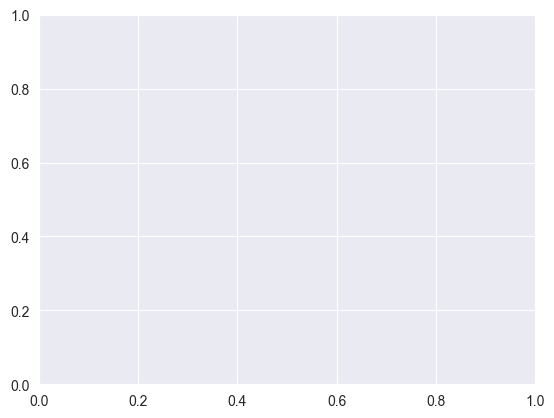

In [71]:
from sklearn.tree import DecisionTreeRegressor
reg =DecisionTreeRegressor()
reg.fit(X_train, y_train)
reg.score(X_test,y_test)
ypred = reg.predict(X_test)

plt.figure()
plt.scatter(X_train, y_train, s=20, edgecolor="black", c="darkorange", label="data")
plt.plot(X_test, ypred, color="cornflowerblue", label="max_depth=2", linewidth=2)
plt.xlabel("data")
plt.ylabel("target")
plt.title("Decision Tree Regression")
plt.legend()
plt.show()

Evaluation